# POPPY Simulation: Magellan Telescope

In [1]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm 
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)

POPPY Version: 0.6.0rc1


## Initiate the optical elements and variables
- The values for the Magellan telescope pulled from Oli's MagAO-X zemax file.

### To-do (not priority):
- Figure out pupil design to add as secondary obscuration

In [2]:
testWavelength = 656e-9 * u.m # H-alpha band for NSF MagAO-X
npix = 256  # resolution

# physical radius values
M1_radius = 3.239204 * u.m 
M2_radius = 0.632573 * u.m 
#M3_radius = 0.334947 * u.m 
M3_radius = 0.439879 * u.m

# radius of curvature values
M1_roc = 16.26 * u.m
M2_roc = 2.862820 * u.m
fl_M1 = 8.128 * u.m
fl_M2 = M2_roc/2

# propagation distances from Zemax file
d_m1_m2 = 9.72205 * u.m
d_m2_m3 = 9.02279 * u.m
d_m3_f11fp = 4.979516 * u.m 

# intermediary distances
d_m1fp_m2 = d_m1_m2 - fl_M1
d_m2_f11fp = d_m2_m3 + d_m3_f11fp

M1 = poppy.QuadraticLens(fl_M1, name='M1')
M2 = poppy.QuadraticLens(fl_M2, name='M2')
# M3 is a flat mirror so nothing to declare here

## Begin Magellan Telescope build

### Check Focal plane PSF of primary mirror

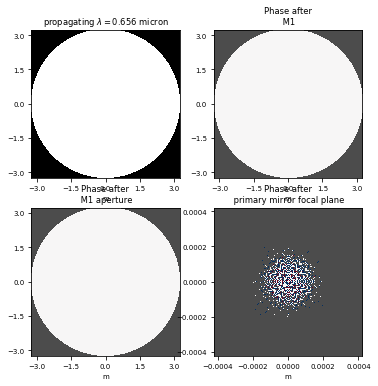

In [3]:
mag_tel = poppy.FresnelOpticalSystem(pupil_diameter=2*M1_radius, 
                                       npix=npix*4,
                                       beam_ratio=0.34)#beam_ratio is the oversampling convention used in PROPER

# Entrance Aperture
mag_tel.add_optic(poppy.CircularAperture(radius=M1_radius))
# Add line of code here for pupil dimensions but need to get more info about spider + center obscuration

# NOTE: Surface # count determined by Laird's MagAO-X spreadsheet design.

# Surface -6: Primary Mirror (M1)
mag_tel.add_optic(M1)
mag_tel.add_optic(poppy.CircularAperture(radius=M1_radius,name="M1 aperture"))

# Look at the focal point of primary mirror
mag_tel.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="primary mirror focal plane"), distance=fl_M1)

matplotlib.rcParams["font.size"]=7
plt.figure(figsize=[6,6])
m1psf, m1_wfs = mag_tel.calcPSF(wavelength=testWavelength,
                                      display_intermediates=True,
                                      return_intermediates=True)

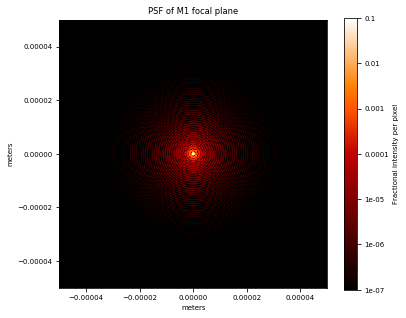

In [4]:
plt.figure(figsize=[6,5])
poppy.display_PSF(m1psf, imagecrop = 0.0001)
plt.title("PSF of M1 focal plane")
plt.xlabel("meters")
plt.ylabel("meters")

### Observe F/11 PSF from telescope

In [5]:
# Surface -5: Secondary Mirror (M2)
mag_tel.add_optic(M2, distance=d_m1fp_m2)
mag_tel.add_optic(poppy.CircularAperture(radius=M2_radius,name="M2 aperture"))

# Surface -4: Tertiary Mirror (M3, flat mirror)
mag_tel.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="M3 (flat)"), distance=d_m2_m3)
mag_tel.add_optic(poppy.CircularAperture(radius=M3_radius, name="M3 (flat) aperture"))

# Surface -3: F/11 Focal Plane
mag_tel.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/11 focal plane"), distance=d_m3_f11fp)

mag_tel.describe()

	Entrance pupil diam:  6.478408 m	npix: 1024	Beam ratio:0.34
	Optic: Circle, radius=3.239204 m
	Lens: M1, with focal length 8.128 m
	Optic: M1 aperture
	Propagation distance:  8.128 m
	Optic: primary mirror focal plane
	Propagation distance:  1.5940499999999993 m
	Lens: M2, with focal length 1.43141 m
	Optic: M2 aperture
	Propagation distance:  9.02279 m
	Optic: M3 (flat)
	Optic: M3 (flat) aperture
	Propagation distance:  4.979516 m
	Optic: F/11 focal plane


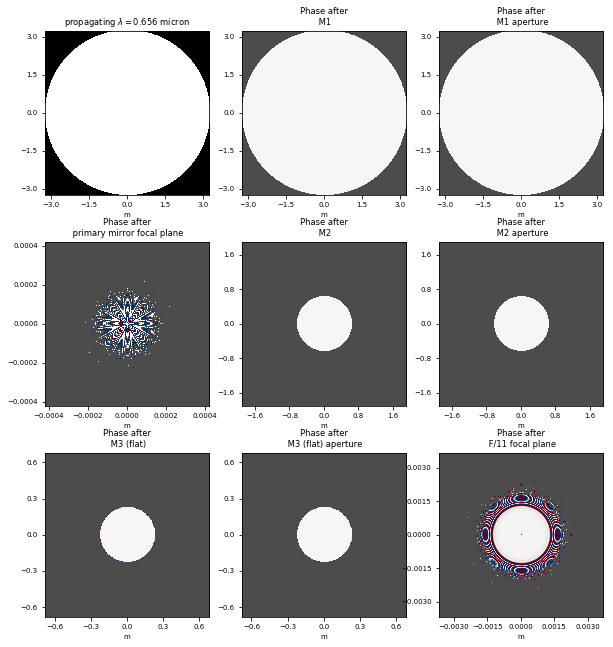

In [6]:
plt.figure(figsize=[10,11])
f11fp_psf, f11fp_wfs = mag_tel.calcPSF(wavelength=testWavelength,
                                      display_intermediates=True,
                                      return_intermediates=True)

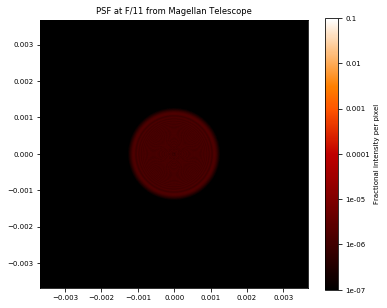

In [7]:
plt.figure(figsize=[6,5])
poppy.display_PSF(f11fp_psf)
plt.title("PSF at F/11 from Magellan Telescope")

Find where the gaussian beam waist is:

In [8]:
last_wave=f11fp_wfs[-1]
print("Gaussian beam parameters:\n"+last_wave.param_str)


Gaussian beam parameters:
w_0:4.611e-06 m, z_w0=2.375e+01 m
z=2.372e+01 m, z_r=1.018e-04 m


Distance to waist: 0.027078593987432953 m


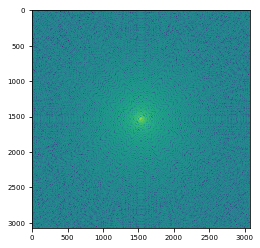

In [9]:
delta=last_wave.z_w0-last_wave.z
print("Distance to waist: "+str(delta))
last_wave.propagate_fresnel(delta)
plt.imshow(np.log10(last_wave.intensity))

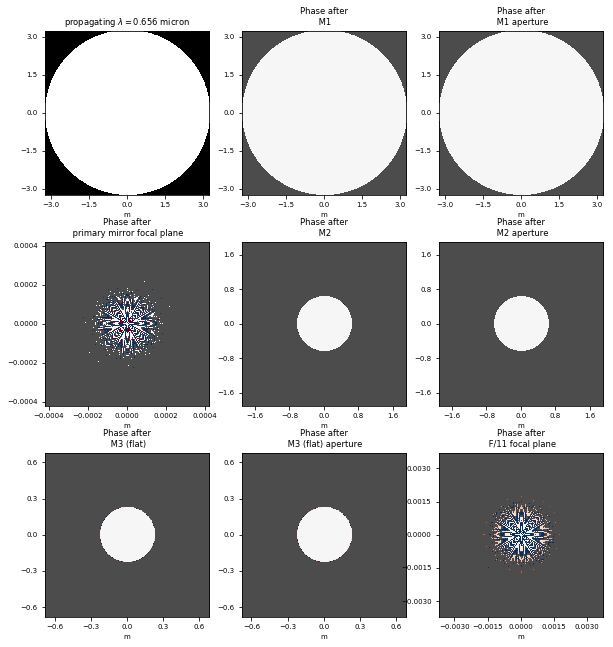

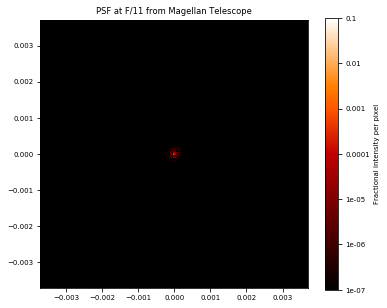

In [10]:
mag_tel = poppy.FresnelOpticalSystem(pupil_diameter=2*M1_radius, 
                                       npix=npix*4,
                                       beam_ratio=0.34)
#beam_ratio is the oversampling convention used in PROPER

# Entrance Aperture
mag_tel.add_optic(poppy.CircularAperture(radius=M1_radius))
# Add line of code here for pupil dimensions but need to get more info about spider + center obscuration

# NOTE: Surface # count determined by Laird's MagAO-X spreadsheet design.

# Surface -6: Primary Mirror (M1)
mag_tel.add_optic(M1)
mag_tel.add_optic(poppy.CircularAperture(radius=M1_radius,name="M1 aperture"))

# Look at the focal point of primary mirror
mag_tel.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                           name="primary mirror focal plane"), 
                  distance=fl_M1)

                   
# Surface -5: Secondary Mirror (M2)
mag_tel.add_optic(M2, distance=d_m1fp_m2)
mag_tel.add_optic(poppy.CircularAperture(radius=M2_radius,name="M2 aperture"))

# Surface -4: Tertiary Mirror (M3, flat mirror)
mag_tel.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                           name="M3 (flat)"), distance=d_m2_m3)
mag_tel.add_optic(poppy.CircularAperture(radius=M3_radius, name="M3 (flat) aperture"))

# Surface -3: F/11 Focal Plane
mag_tel.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                           name="F/11 focal plane"), 
                  distance=d_m3_f11fp+delta)
plt.figure(figsize=[10,11])
f11fp_psf, f11fp_wfs = mag_tel.calcPSF(wavelength=testWavelength,
                                      display_intermediates=True,
                                      return_intermediates=True)
plt.figure(figsize=[6,5])
poppy.display_PSF(f11fp_psf)
plt.title("PSF at F/11 from Magellan Telescope")